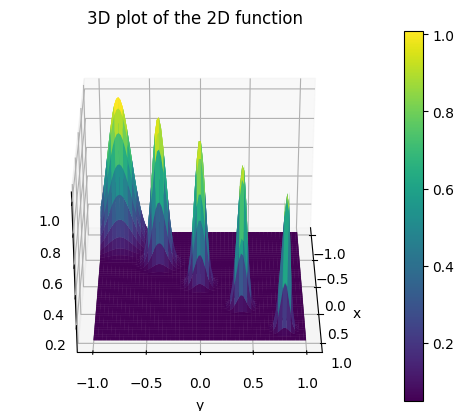

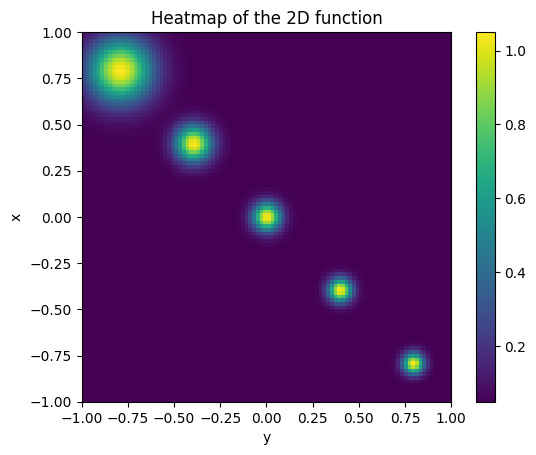

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os

# Parameters
n_peak = 5
n_num_per_peak = 20
n_sample = n_peak * n_num_per_peak

# Create a grid of points
x = np.linspace(-1, 1, n_sample)
y = np.linspace(-1, 1, n_sample)
x_grid, y_grid = np.meshgrid(x, y)

# Define centers for the Gaussians
x_centers = 2/n_peak * (np.arange(n_peak) - n_peak/2 + 0.5)
y_centers = 2/n_peak * (np.arange(n_peak) - n_peak/2 + 0.5)

# Initialize the 2D function
f_xy = np.zeros_like(x_grid)

# Sum Gaussian functions with increased variance
scaling_factor = 70  # Decrease this factor to increase the variance
for i, (mu_x, mu_y) in enumerate(zip(x_centers, y_centers)):
    sigma_x = np.sqrt(1 / (1 + 2*i))
    sigma_y = np.sqrt(1 / (1 + 2*i))
    f_xy += np.exp(-((x_grid - mu_x)**2 / (2 * sigma_x**2) + (y_grid - mu_y)**2 / (2 * sigma_y**2)) * scaling_factor) + 0.01  # adding 0.05 for better clarity on graphs

# Plotting the 3D surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, f_xy, cmap='viridis')
fig.colorbar(ax.plot_surface(x_grid, y_grid, f_xy, cmap='viridis'))

# Rotate the plot to see the 3D plot
ax.view_init(30, 0)
plt.title('3D plot of the 2D function')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('../../Figures/2D_Gaussian_3D_plot.png')
plt.show()

# Plotting the heatmap
plt.imshow(f_xy, cmap='viridis', extent=[-1, 1, -1, 1])
plt.colorbar()
plt.title('Heatmap of the 2D function')
plt.xlabel('y')
plt.ylabel('x')
plt.savefig('../../Figures/2D_Gaussian_heatmap.png')
plt.show()


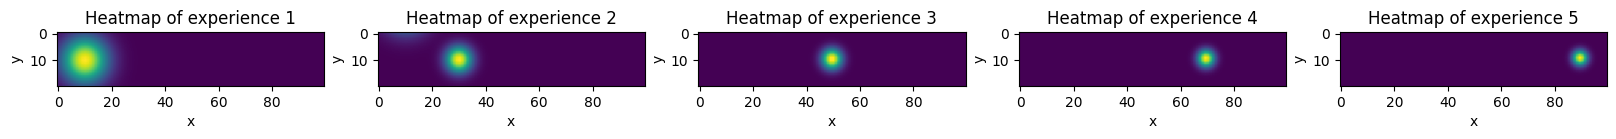

In [68]:
# Prepare training data
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()
z_flat = f_xy.flatten()

# Create the input features as pairs of (x, y)
train_input = np.vstack((x_flat, y_flat)).T
train_label = z_flat

# Convert to PyTorch tensors
train_input_tensor = torch.tensor(train_input, dtype=torch.float32)
train_label_tensor = torch.tensor(train_label, dtype=torch.float32).view(-1, 1)

# Split data into 5 experiences
n_experiences = 5
experience_size = train_input_tensor.shape[0] // n_experiences

experience_train_data = []
experience_train_labels = []

fig, axs = plt.subplots(1, n_experiences, figsize=(20, 5))
for i in range(n_experiences):
    start_idx = i * experience_size
    end_idx = (i + 1) * experience_size
    experience_train_data.append(train_input_tensor[start_idx:end_idx])
    experience_train_labels.append(train_label_tensor[start_idx:end_idx])
    # Plot the data as a heatmap
    axs[i].imshow(train_label_tensor[start_idx:end_idx].view(20,100), cmap='viridis')
    axs[i].set_title(f'Heatmap of experience {i+1}')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    
plt.show()



checkpoint directory created: ./model
saving model version 0.0
Training on Experience 0


| train_loss: 7.20e-04 | test_loss: 4.21e-01 | reg: 1.00e+01 | : 100%|█| 40/40 [00:09<00:00,  4.16it

saving model version 0.1


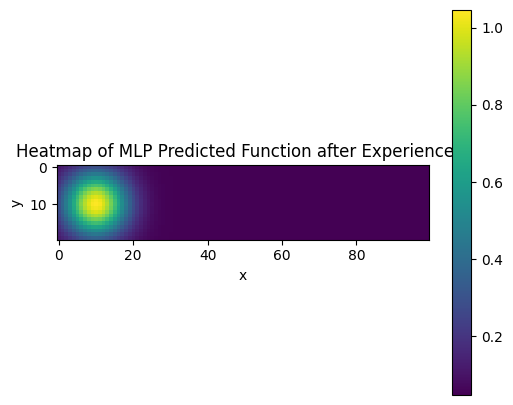

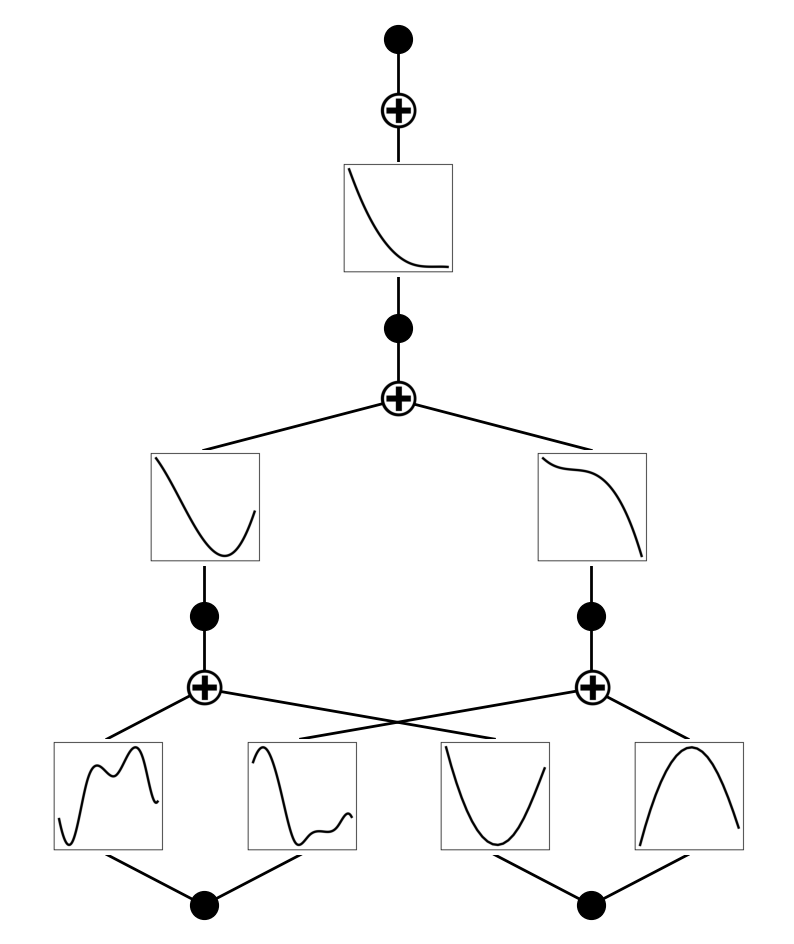

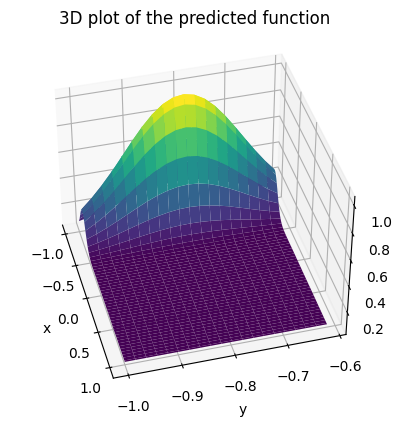

Training on Experience 1


| train_loss: 5.83e-03 | test_loss: 5.02e-01 | reg: 9.92e+00 | : 100%|█| 40/40 [00:10<00:00,  3.92it

saving model version 0.2


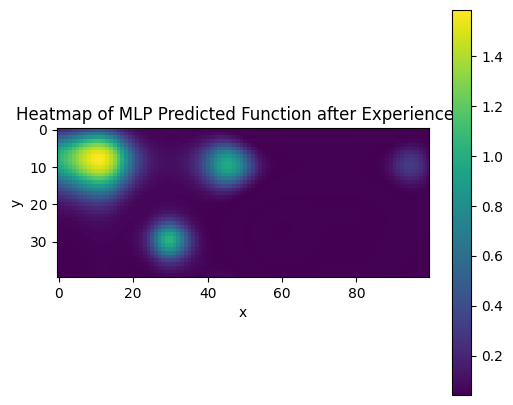

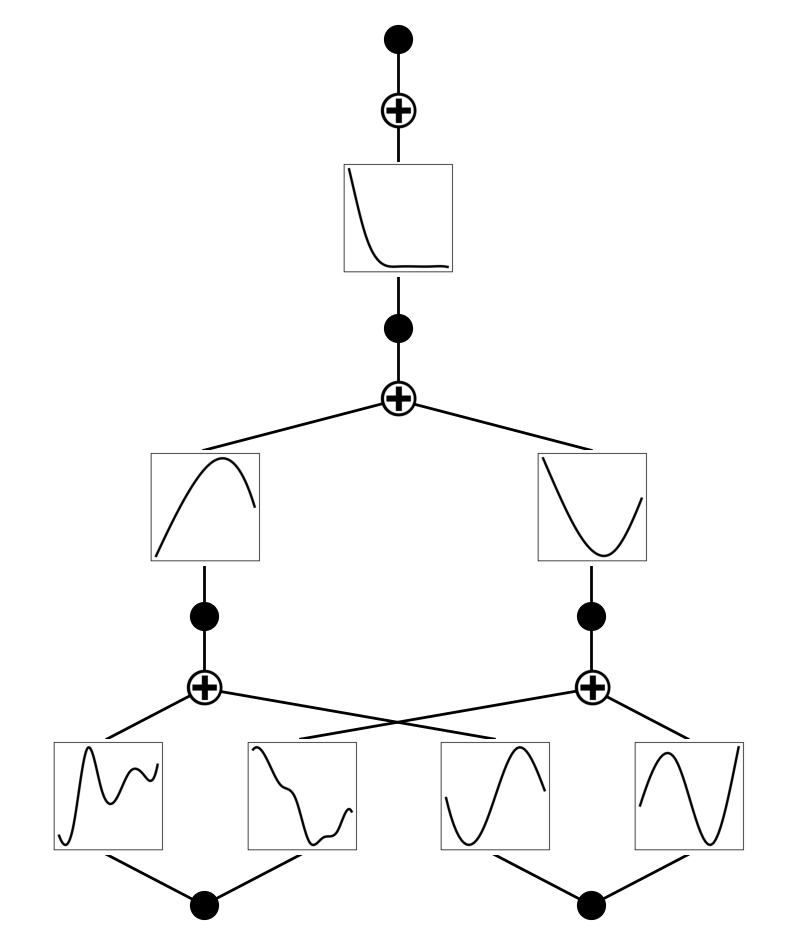

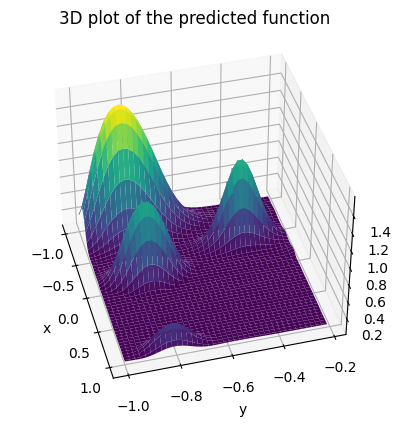

Training on Experience 2


| train_loss: 7.00e-03 | test_loss: 9.08e-01 | reg: 1.15e+01 | : 100%|█| 40/40 [00:09<00:00,  4.12it

saving model version 0.3


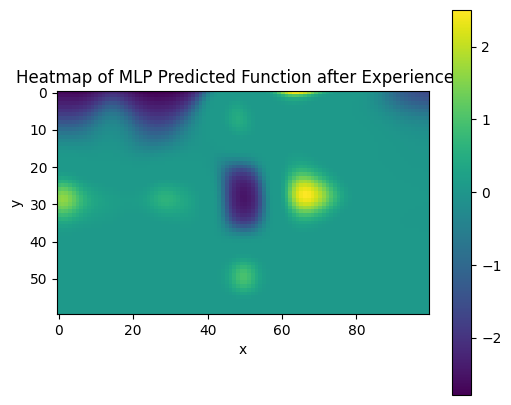

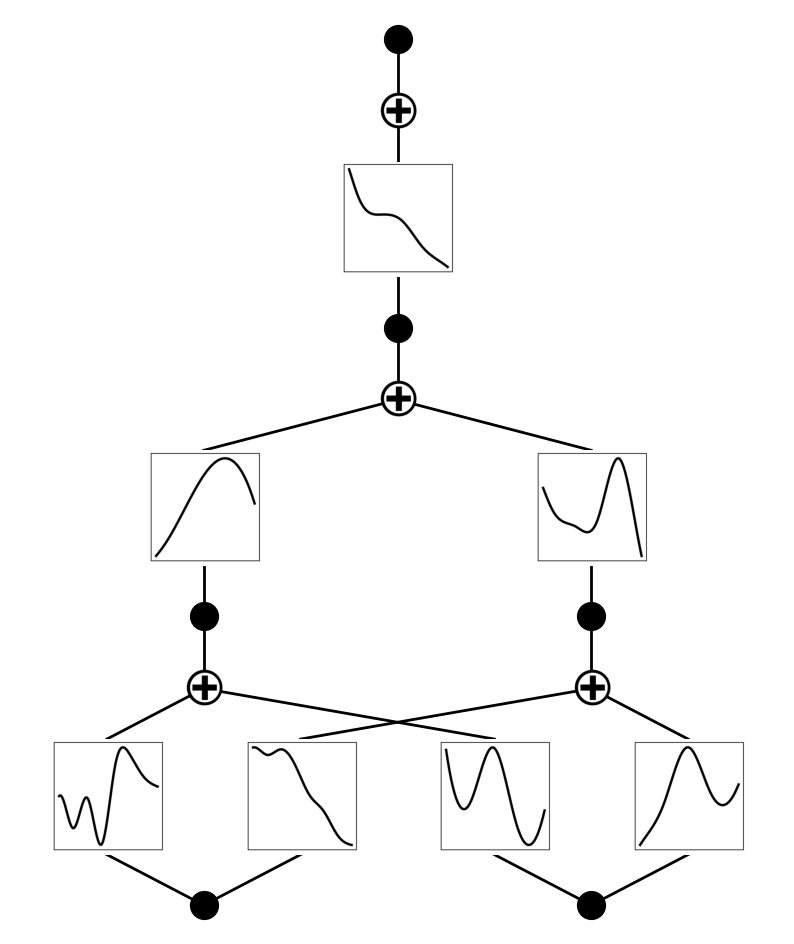

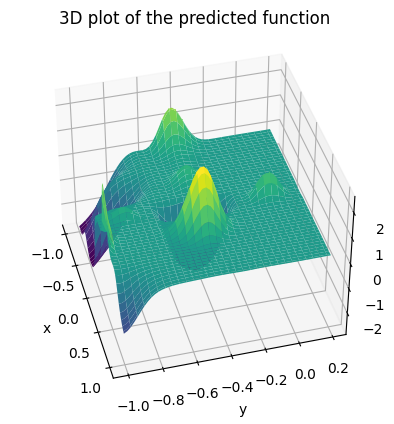

Training on Experience 3


| train_loss: 1.58e-03 | test_loss: 7.46e-01 | reg: 8.28e+00 | : 100%|█| 40/40 [00:10<00:00,  3.95it

saving model version 0.4


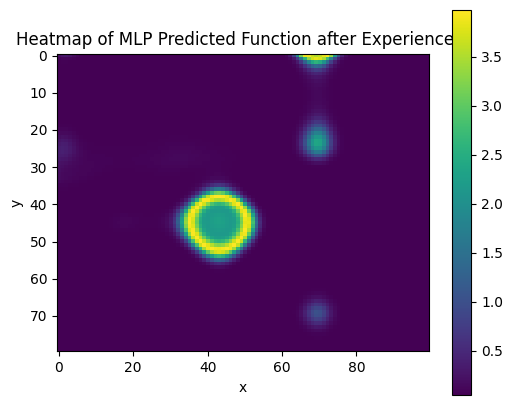

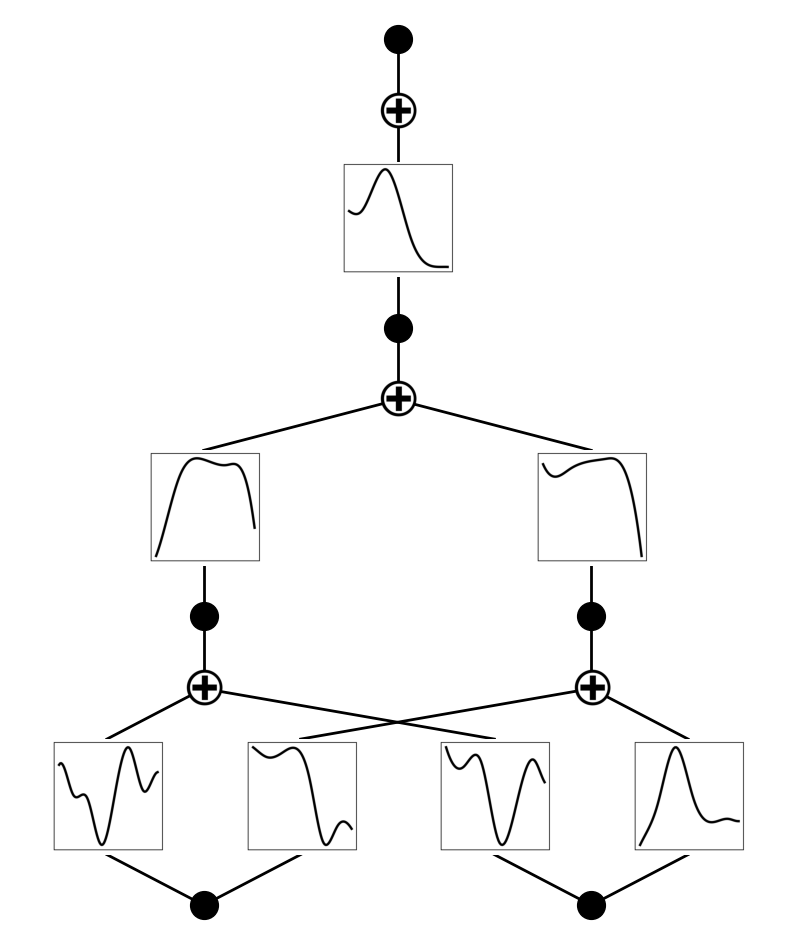

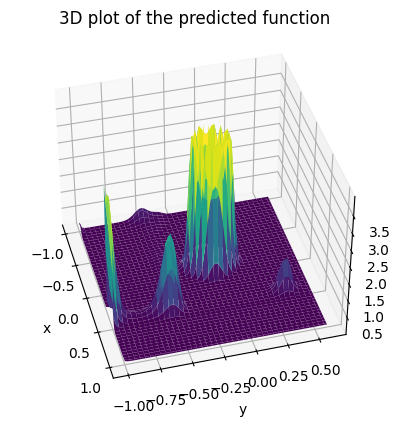

Training on Experience 4


| train_loss: 7.47e-02 | test_loss: 1.87e-01 | reg: 1.50e+01 | : 100%|█| 40/40 [00:10<00:00,  3.98it

saving model version 0.5


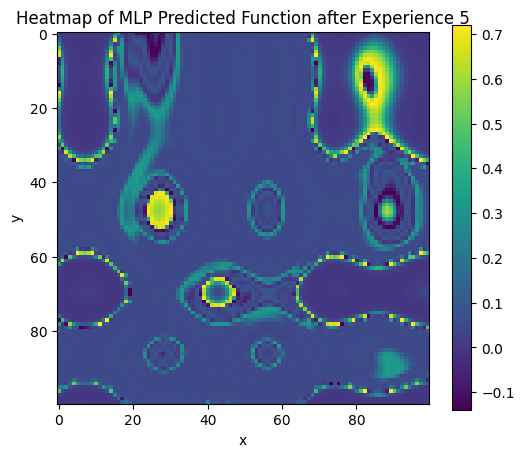

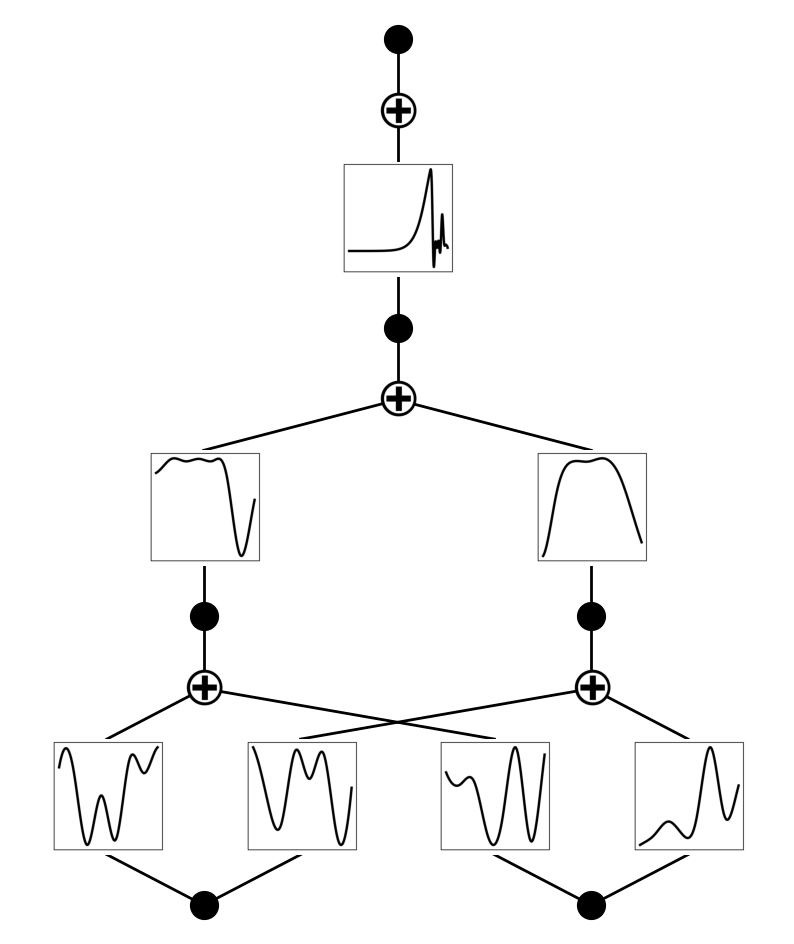

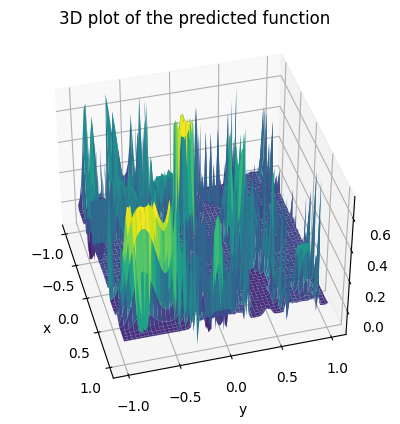

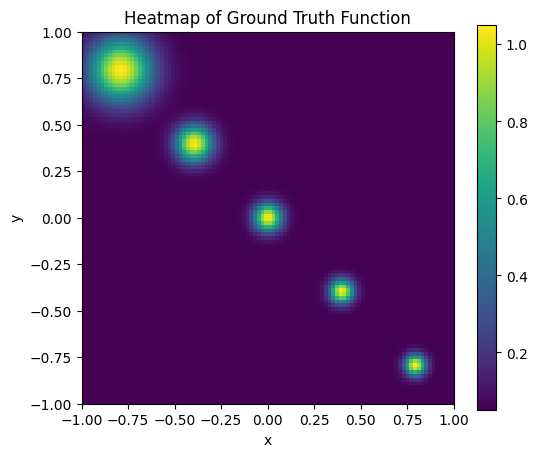

In [120]:
from kan import KAN

# 2,2,3,1 architecture with grid=6/7 and k=5 => gives symmetric properties
# 2,2,3,1 architecture with grid=6 and k=5 => shows symmetric properties
# 2,4,4,1 architecture with grid=6 and k=5 => shows position preservation
model = KAN(width=[2,2,1,1], grid=7, k=3, sp_trainable=False, sb_trainable=False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Training and evaluation loop
num_epochs = 100
batch_size = 64

# Prepare the dataset for KAN
dataset = {}
test_input = np.array(experience_train_data[0])
test_label = np.array(experience_train_labels[0])

to_test = [test_input]
for i in range(1,n_experiences):
    test_input = np.vstack((test_input, experience_train_data[i].numpy()))
    test_label = np.vstack((test_label, experience_train_labels[i].numpy()))
    to_test.append(test_input)
dataset['test_input'] = torch.from_numpy(test_input).to(device)
dataset['test_label'] = torch.from_numpy(test_label).to(device)

def sample(data,seed=0):
    n = data.shape[0]
    # Use the same sed for data and labels
    np.random.seed(seed)
    idx = np.random.choice(n,n, replace=False)
    np.random.seed(int.from_bytes(os.urandom(4)))
    return data[idx]

# fig, axs = plt.subplots(1, n_experiences, figsize=(20, 5))
# Train the model
for i in range(n_experiences):
    print(f'Training on Experience {i}')

    # Use the same seed for identically splitting data and labels
    rnd = int.from_bytes(os.urandom(4))
    dataset['train_input'] = torch.from_numpy(sample(np.array(experience_train_data[i]),rnd)).to(device)
    dataset['train_label'] = torch.from_numpy(sample(np.array(experience_train_labels[i]),rnd)).to(device)

    #KAN training
    model.fit(dataset=dataset,opt='LBFGS', steps=40, update_grid=False)

    # Evaluation
    with torch.no_grad():
        predictions = model(torch.from_numpy(np.array(to_test[i])).to(device)).cpu().numpy()
    
    # Reshape predictions to the original grid shape
    predictions_grid = predictions.reshape(-1, 100)
    
    # Plotting the predicted function
    plt.figure(figsize=(6, 5))
    plt.imshow(predictions_grid, cmap='viridis')
    plt.colorbar()
    plt.title(f'Heatmap of MLP Predicted Function after Experience {i + 1}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


    # axs[i].imshow(predictions_grid, cmap='viridis', extent=[-1, 1,-1, -1+2*(i+1)/5])
    # axs[i].set_title(f'KAN prediction after experience {i+1}')
    # axs[i].set_xlabel('x')
    # axs[i].set_ylabel('y')

    # Plot the model
    model.plot(beta=100, scale=1)
    plt.show()
    
    #plot the predictions in 3d
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_grid[:20*(i+1)], y_grid[:20*(i+1)], predictions_grid, cmap='viridis')

    # Rotate the plot to see the 3D plot
    ax.view_init(40, -15)
    plt.title('3D plot of the predicted function')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

# torch.save(model.state_dict(), 'kan_2d_gaussian_continual.pth')

# Plotting the ground truth function
plt.figure(figsize=(6, 5))
plt.imshow(f_xy, cmap='viridis', extent=[-1, 1, -1, 1])
plt.colorbar()
plt.title('Heatmap of Ground Truth Function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

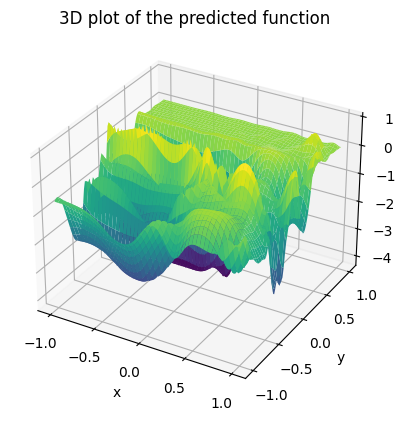

In [7]:
#plot the predictions in 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, predictions_grid, cmap='viridis')

# Rotate the plot to see the 3D plot
# ax.view_init(40, 15)
plt.title('3D plot of the predicted function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Training KAN

Prediction of KAN after each stage

In [ ]:
import ipywidgets as widgets 
from ipywidgets import interact, interactive, fixed 
model.plot(beta=100)
layers = []
for layer in model.modules():
    layers.append(layer)

layer = layers[0]
print(layers)

# def plot_curve_with_slider(j):
#     x_conv, y_conv = layer[1].plot_curve(0, j, num_pts=100, num_extrapolate_bins=3)
#     x_conv, y_conv = x_conv.cpu().numpy(), y_conv.cpu().numpy()
#     plt.plot(x_conv, y_conv, label='Conv')
#     plt.legend()
#     plt.show()
# # Create an interactive slider
# interactive_plot = interactive(plot_curve_with_slider, j=widgets.SelectionSlider(options=[i for i in range(1)]))
# output = interactive_plot.children[-1]
# output.layout.height = '500px'
# interactive_plot

NameError: name 'model' is not defined